#**The North Face Product Recommendation Sytem**

**Extract and load dataset from Kaggle**

In [ ]:
!kaggle datasets download -d cclark/product-item-data

Dataset URL: https://www.kaggle.com/datasets/cclark/product-item-data
License(s): unknown
100% 137k/137k [00:00<00:00, 455kB/s]
100% 137k/137k [00:00<00:00, 455kB/s]


**Import Libraries**

In [61]:
import pandas as pd
import spacy
import numpy as np
import matplotlib.pyplot as plt
import re
import html
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from spacy.lang.en.stop_words import STOP_WORDS

In [62]:
# Load SpaCy English model
nlp = spacy.load("en_core_web_sm")

###**Data Overview & Preprocessing**

In [63]:
# Load dataset
df = pd.read_csv("/content/sample-data.csv")
df.head()

id                                        description
0   1  Active classic boxers - There's a reason why o...
1   2  Active sport boxer briefs - Skinning up Glory ...
2   3  Active sport briefs - These superbreathable no...
3   4  Alpine guide pants - Skin in, climb ice, switc...
4   5  Alpine wind jkt - On high ridges, steep ice an...

###**Text Preprocessing**

In [64]:
# Remove special characters
df["clean_description"] = df["description"].astype(str).apply(lambda x: html.unescape(x))
df["clean_description"] = df["clean_description"].str.replace(r"<.*?>", " ", regex=True)
df["clean_description"] = df["clean_description"].str.replace(r"[^a-zA-Z0-9\s]", " ", regex=True)

In [65]:
# Text preprocessing function
def preprocess_text(text):
    doc = nlp(text.lower())  # Convert to lowercase
    tokens = [token.lemma_ for token in doc if token.text not in STOP_WORDS and token.is_alpha]
    return " ".join(tokens)

# Apply preprocessing
df["clean_description"] = df["clean_description"].apply(preprocess_text)

###**Tokenization**

In [66]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["clean_description"])

##**Clustering with DBSCAN**

In [67]:
# Clustering with DBSCAN
clustering_model = DBSCAN(eps=0.5, min_samples=5, metric='cosine')
df["cluster"] = clustering_model.fit_predict(X)

In [68]:
df_clusters = df[df['cluster'] != -1].groupby('cluster')
df_clusters.head()

id                                        description  \
5      6  Ascensionist jkt - Our most technical soft she...   
14    15  Borderless shorts-11 in. - Go forward where ot...   
15    16  Borderless shorts-7 in. - One of summertime's ...   
17    18  Cap 1 bottoms - Spring skiing is as transient ...   
19    20  Cap 1 graphic t-shirt - This tee is made from ...   
..   ...                                                ...   
479  480  Borderless messenger shorts - Pair these light...   
483  484  Borderless trek pants - The Ruby Crest trail r...   
484  485  Borderless trek zip-off pants - Made for techn...   
498  499  All-wear cargo shorts - All-Wear Cargo Shorts ...   
499  500  All-wear shorts - Time to simplify? Our All-We...   

                                     clean_description  cluster  
5    ascensionist jkt technical soft shell mountain...       13  
14   borderless short forward cringe borderless sho...        0  
15   borderless short summertime s gift chance free...        0  
17   cap bottom spring skiing transient wind fast l...        1  
19   cap graphic t shirt tee light weight capilene ...        1  
..                                                 ...      ...  
479  borderless messenger short pair lightweight st...        0  
483  borderless trek pant ruby crest trail run dire...        0  
484  borderless trek zip pant technical performance...        0  
498  wear cargo short wear cargo short bask glory s...        3  
499  wear short time simplify wear short prove shor...        3  

[75 rows x 4 columns]

In [69]:
# Save dbscan clusters to csv
dbscan_clusters = pd.DataFrame(df_clusters).to_csv('/content/dbscan_clusters.csv', index=False)

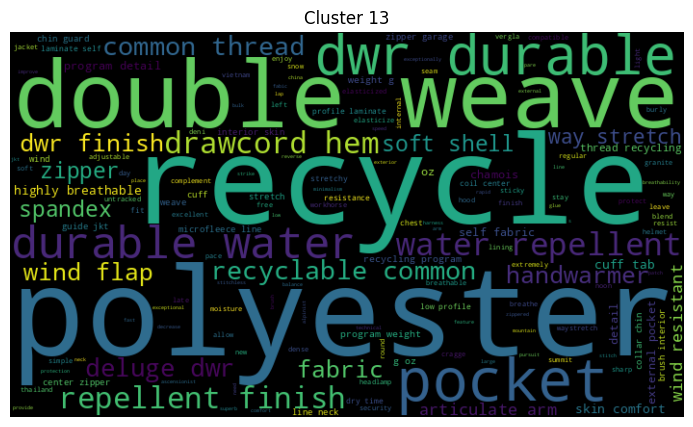

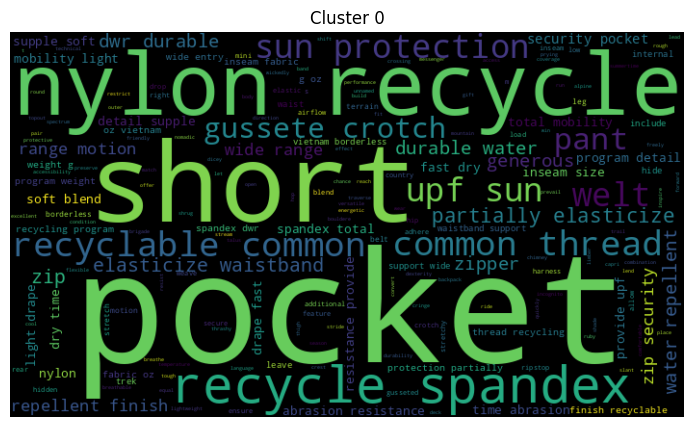

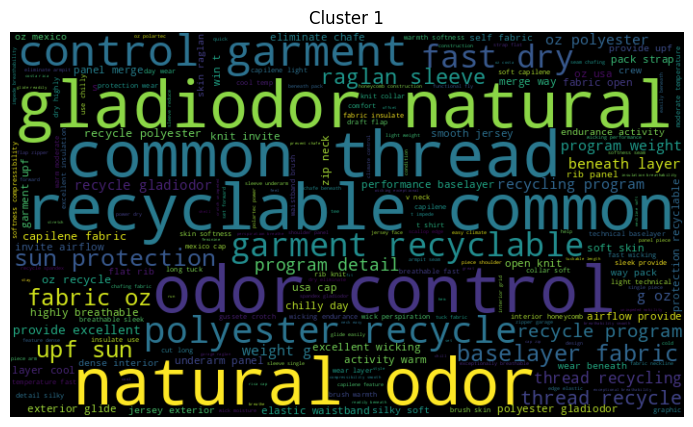

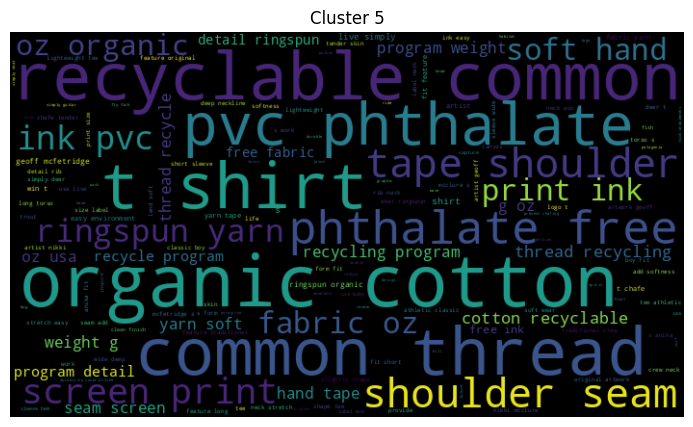

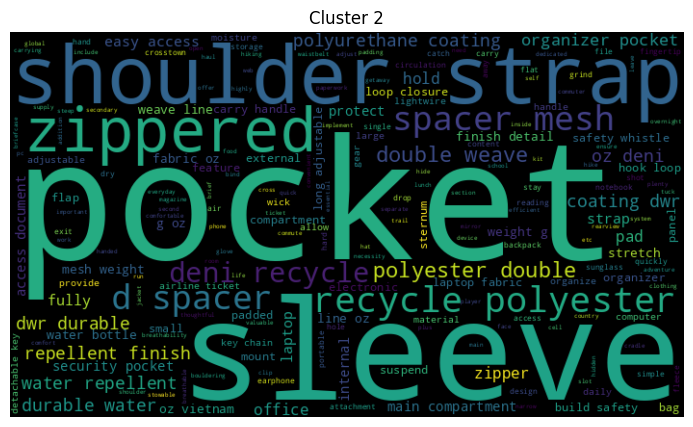

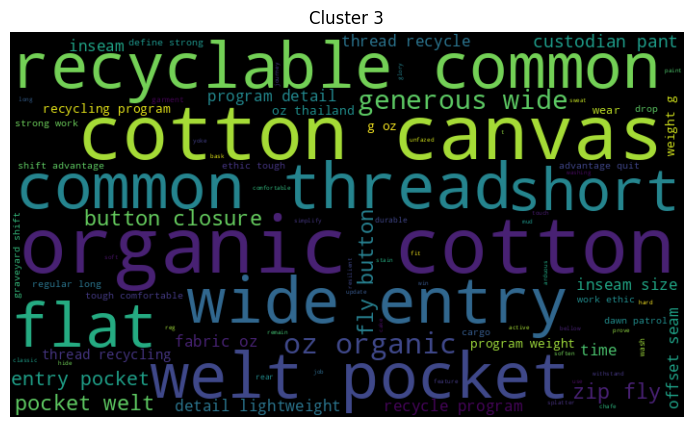

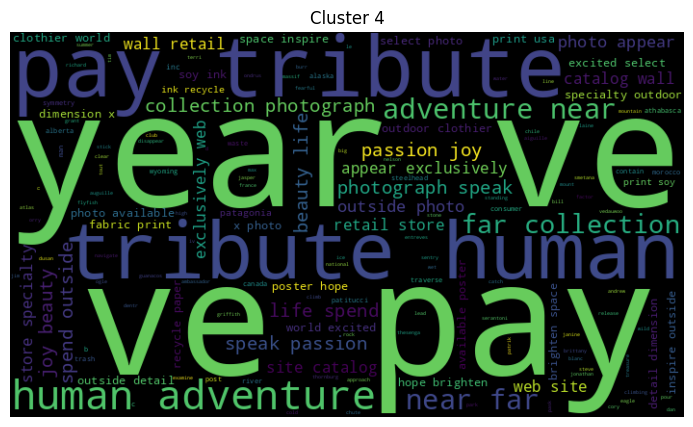

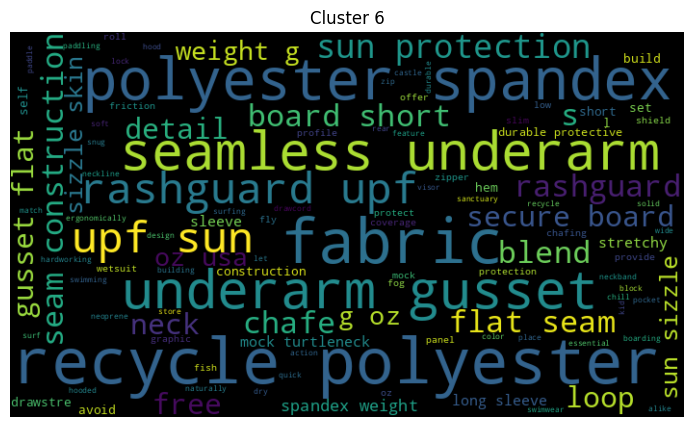

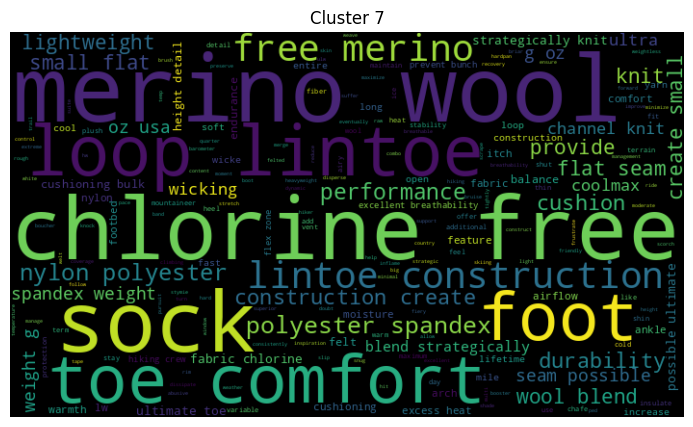

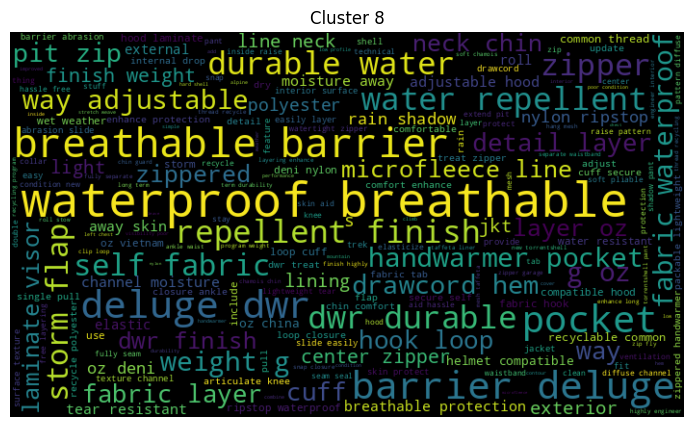

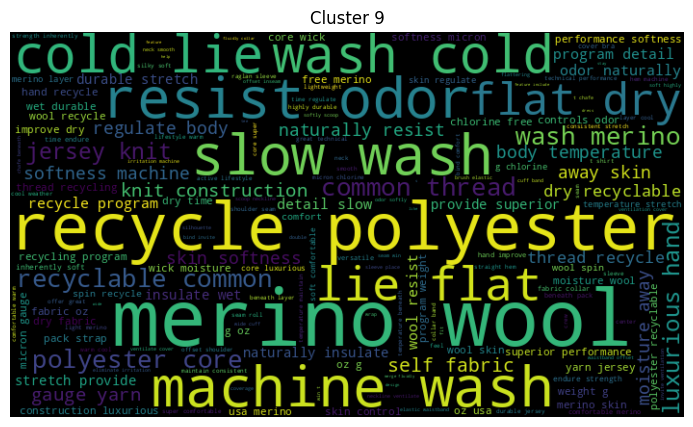

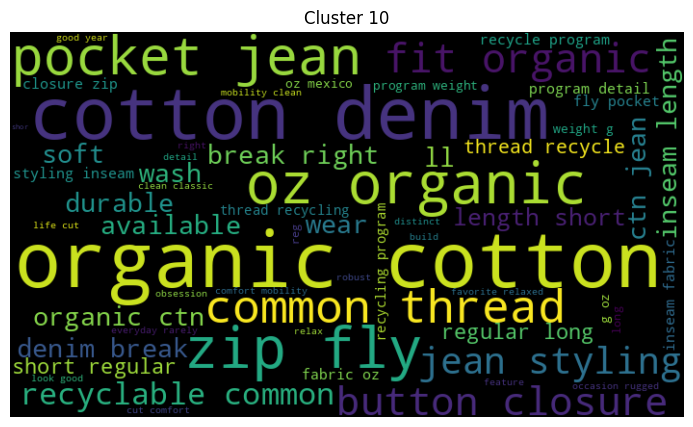

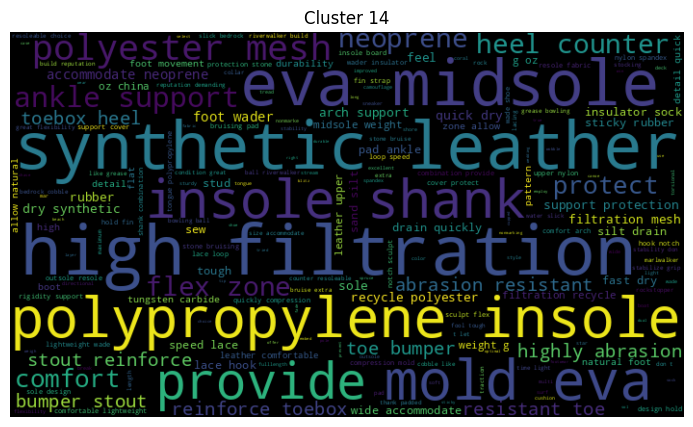

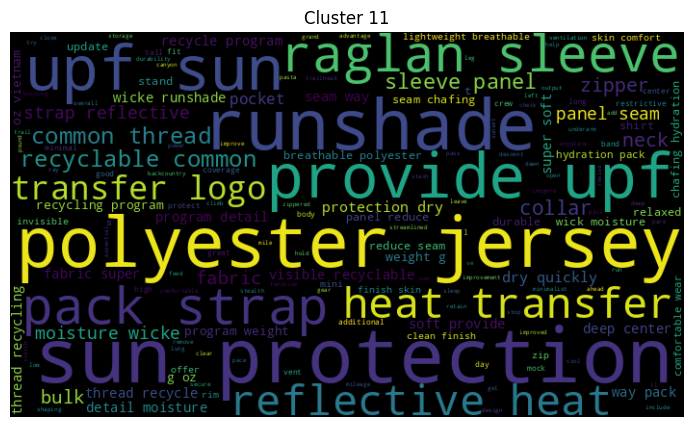

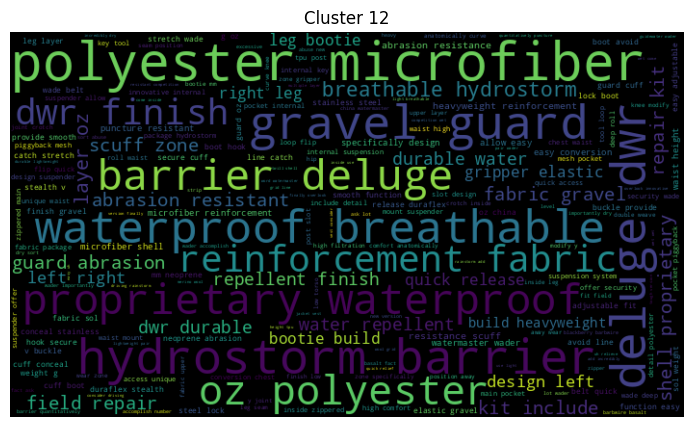

In [70]:
# Generate word clouds for each cluster
clusters = df["cluster"].unique()
for cluster in clusters:
    if cluster == -1:
        continue

    cluster_text = " ".join(df[df["cluster"] == cluster]["clean_description"])
    wordcloud = WordCloud(width=700, height=400, background_color='black', stopwords=STOP_WORDS).generate(cluster_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cluster {cluster}")
    plt.show()

In [71]:
# Save clustered data
df.to_csv("clustered_products.csv", index=False)